<h1 style="text-align:center;color:#0F4C81">Regularization</h1>

## What is Regularization?

Regularization in machine learning is a collection of techniques that help prevent overfitting and improve a model's ability to generalize to new data.

Overfitting occurs when a model memorizes training data details instead of learning the broader patterns within the data. This can lead to poor performance on new data.

Regularization may be defined as any modification or change in the learning algorithm that helps reduce its error over a test dataset, commonly known as generalization error but not on the supplied or training dataset.

In learning algorithms, there are many variants of regularization techniques, each of which tries to cater to different challenges. These can be listed down straightforwardly based on the kind of challenge the technique is trying to deal with:

1. Some try to put extra constraints on the learning of an ML model, like adding restrictions on the range/type of parameter values.
2. Some add more terms in the objective or cost function, like a soft constraint on the parameter values. More often than not, a careful selection of the right constraints and penalties in the cost function contributes to a massive boost in the model's performance, specifically on the test dataset.
3. These extra terms can also be encoded based on some prior information that closely relates to the dataset or the problem statement.
4. One of the most commonly used regularization techniques is creating ensemble models, which take into account the collective decision of multiple models, each trained with different samples of data.

We will now look at ridge regression, lasso regression, and elastic net regression, which implement three different ways to constrain the weights.

### L2 Regularisation: Ridge Regression

Ridge regression (also called _Tikhonov_ regularization) is a regularized version of linear regression: a _regularization term_ equal to $\frac{\alpha}{m}\sum_{i=1}^n \theta_i^2$ is added to the MSE. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized MSE (or the RMSE) to evaluate the model’s performance.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$,
then ridge regression is just linear regression. If $\alpha$ is very large, then all weights end
up very close to zero and the result is a flat line going through the data’s mean.
Equation below presents the ridge regression cost function.

$$
\mathcal{J}(\theta) = \text{MSE}(\theta) + \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$

Note that the bias term $\theta_0$ is not regularized (the sum starts at $i = 1$, not $0$). If we define $w$ as the vector of feature weights ($\theta_1$ to $\theta_n$), then the regularization term is equal to $\frac{\alpha}{m}(\|w\|_2)^2$, where $\|w\|_2$ represents the $l_2$ norm of the weight vecotr. For batch gradient descent, just ass $2\frac{\alpha}{m}w$ to the part of the MSE gradient vector that corresponds to the feature weights, without adding anything to the gradient of the bias term.

> It is important to scale the data (e.g., using a `StandardScaler`) before performing ridge regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

Below plot shows several ridge models that were trained on some very noisy linear data using different α values. On the left, plain ridge models are used, leading to linear predictions. On the right, the data is first expanded using `PolynomialFeatures(degree=10)`, then it is scaled using a `StandardScaler`, and finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing $\alpha$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias.

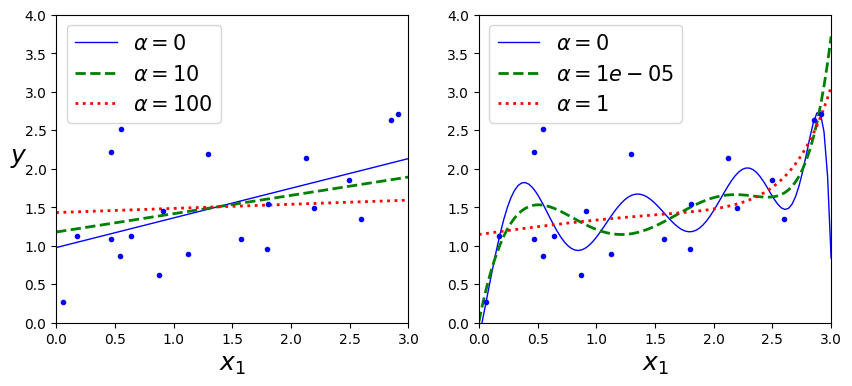

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from matplotlib import pyplot as plt

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kwargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('regul_reg', model)
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, 'b.', linewidth=3)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

As with linear regression, we can perform ridge regression either by computing a closed-form equation or by performing gradient descent. The pros and cons are the same. Below equation shows the closed-form solution, where $I$ is the (n + 1) × (n + 1)
identity matrix, except with a 0 in the top-left cell, corresponding to the bias term.
$$
\hat{\theta} = (X^TX + \alpha I)^{-1}X^Ty
$$

Here is how to perform ridge regression with Scikit-Learn using a closed-form solution (a variant of above equation that uses a matrix factorization technique by André-Louis Cholesky):

In [3]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [4]:
ridge_reg = Ridge(alpha=1, solver='sag', random_state=42) # Stochastic Average Gradient
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

And using stochastic gradient descent:

In [5]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty='l2', alpha=0.1 / m, random_state=42, eta0=0.01, max_iter=1000, tol=None)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.55302613])

The penalty hyperparameter sets the type of regularization term to use. Specifying `l2` indicates that you want `SGD` to add a regularization term to the MSE cost function equal to alpha times the square of the ℓ norm of the weight vector. This is just like ridge regression, except there’s no division by $m$ in this case; that’s why we passed `alpha=0.1 / m`, to get the same result as `Ridge(alpha=0.1)`.

### L1 Regularisation: Lasso Regression

Least absolute shrinkage and selection operator regression (usually simply called lasso regression) is another regularized version of linear regression: just like ridge regression, it adds a regularization term to the cost function, but it uses the $ℓ_1$ norm of the weight vector instead of the square of the $ℓ_2$ norm. Notice that the $ℓ_1$ norm is multiplied by $2α$, whereas the $ℓ_2$ norm was multiplied by $α / m$ in ridge regression. These factors were chosen to ensure that the optimal $α$ value is independent from the training set size: different norms lead to different factors.

$$
\mathcal{J}(\theta) = \text{MSE}(\theta) + 2\alpha \sum_{i=1}^{n} |\theta_i|
$$

The plot is the same thing as above but replaces the ridge models with lasso models and uses different α values.

c:\Python\Python3.10.11\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


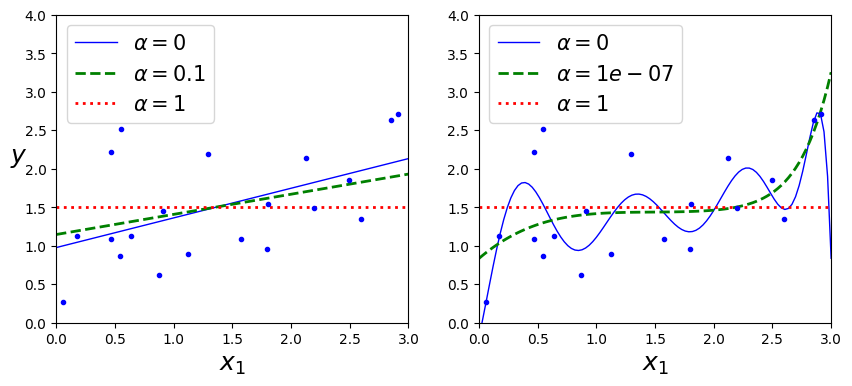

In [6]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.show()

The lasso cost function is not differentiable at $\theta_i = 0 (\text{ for } i = 1, 2, \dots, n)$, but gradient descent still works if you use a _subgradient vector_ **g** instead when any $\theta_i = 0$. Below equation shows a subgradient vector equation you can use for gradient descent with the lasso cost function.

$$
g(\theta, J) = \nabla_{\theta}\text{MSE}(\theta) + 2\alpha \begin{pmatrix} sign(\theta_1) \\
sign(\theta_2) \\ \vdots \\ sign(\theta_n) \end{pmatrix}
$$

$$
sign(\theta_i) = \begin{cases} -1 \text{ if } \theta_i < 0 \\
 0 \text{ if } \theta_i = 0 \\
+1 \text{ if } \theta_i > 0 \end{cases}
$$

Here is a small Scikit-Learn example using the `Lasso` class:

In [7]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

And using stochastic gradient descent:

In [8]:
sgd_reg = SGDRegressor(penalty='l1', alpha=0.1, tol=None)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.53681905])

### Elastic Net Regression

**Elastic net** regression is a middle ground between ridge regression and lasso
regression. The regularization term is a weighted sum of both ridge and lasso’s
regularization terms, and you can control the mix ratio $r$. When $r = 0$, elastic net is equivalent to ridge regression, and when $r = 1$, it is equivalent to lasso regression.

$$
\mathcal{J}(\theta) = \text{MSE}(\theta) + r(2\alpha \sum_{i=1}^{n} |\theta_i|) + (1-r)(\frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2)
$$

So when should you use elastic net regression, or ridge, lasso, or plain linear
regression (i.e., without any regularization)? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain linear regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer lasso or elastic net because they tend to reduce the useless features’ weights down to zero, as discussed earlier. In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here is a short example that uses Scikit-Learn’s ElasticNet (`l1_ratio` corresponds to the mix ratio `r`):

In [9]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [10]:
elastic_net.coef_

array([0.30462619])

In [11]:
ridge_reg.coef_

array([[0.36286075]])

In [12]:
lasso_reg.coef_

array([0.26167212])

### Early Stopping

A very different way to regularize iterative learning algorithms such as gradient descent is to stop training as soon as the validation error reaches a minimum. This is called *early stopping*. The below figure shows a complex model (in this case, a high-degree polynomial regression model) being trained with batch gradient descent on the quadratic dataset we used earlier. As the epochs go by, the algorithm learns, and its prediction error (RMSE) on the training set goes down, along with its prediction error on the validation set. After a while, though, the validation error stops decreasing and starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch”.

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, y_train = X[:m // 2], y[:m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

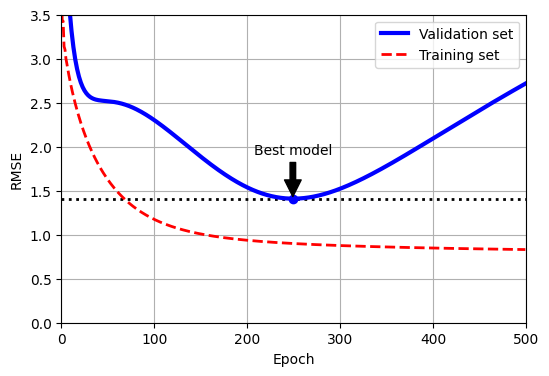

In [20]:
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_val_prep = preprocessing.transform(X_valid)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_val_predict = sgd_reg.predict(X_val_prep)
    val_error = root_mean_squared_error(y_valid, y_val_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = root_mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)

best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model', xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], 'k:', linewidth=2)
plt.plot(val_errors, 'b-', linewidth=3, label='Validation set')
plt.plot(best_epoch, best_valid_rmse, 'bo')
plt.plot(train_errors, 'r--', linewidth=2, label='Training set')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

In [21]:
best_model

SGDRegressor(eta0=0.002, penalty=None, random_state=42)

In [47]:
best_epoch

np.int64(249)

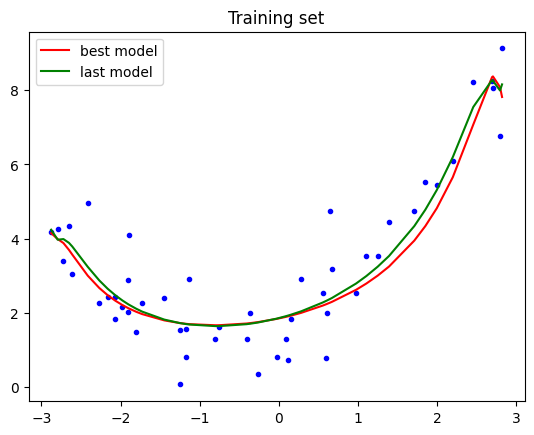

In [57]:
x = sorted(X_train)
y_pred = best_model.predict(preprocessing.transform(x))
y_pred_last = sgd_reg.predict(preprocessing.transform(x)) # last model
plt.plot(X_train, y_train, 'b.')
plt.plot(x, y_pred, 'r', label='best model')
plt.plot(x, y_pred_last, 'g', label='last model')
plt.title('Training set')
plt.legend()
plt.show()

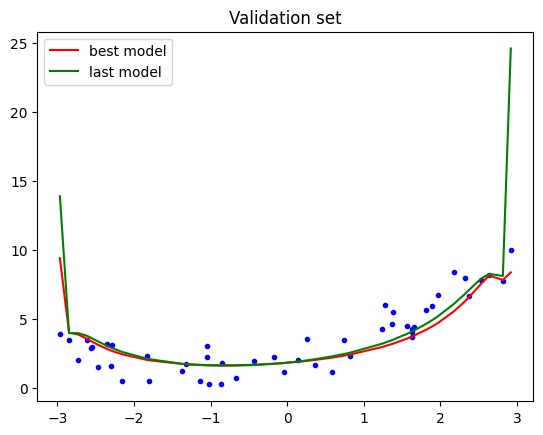

In [58]:
x = sorted(X_valid)
y_pred = best_model.predict(preprocessing.transform(x))
y_pred_last = sgd_reg.predict(preprocessing.transform(x)) # last model
plt.plot(X_valid, y_valid, 'b.')
plt.plot(x, y_pred, 'r', label='best model')
plt.plot(x, y_pred_last, 'g', label='last model')
plt.title('Validation set')
plt.legend()
plt.show()

> With stochastic and mini-batch gradient descent, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.